In [1]:
!pip install torchinfo

**Import Libraries**

In [2]:
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
import numpy as np
import cv2
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms
from torchinfo import summary
import torchvision.models as models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score
import PIL
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import OrderedDict
import platform
import psutil
import random
import glob
from tqdm import tqdm
from PIL import Image
from torchvision import transforms
from torchvision.transforms import ColorJitter, RandomRotation, RandomResizedCrop
from torchvision.transforms.functional import gaussian_blur
from PIL import ImageOps
from tabulate import tabulate

**Configuration**

In [3]:
cpu_info = platform.processor()

ram_info = psutil.virtual_memory()
total_ram_gb = ram_info.total / (1024 ** 3)

try:
    gpu_info = !nvidia-smi --query-gpu=gpu_name --format=csv
    gpu_name = gpu_info[1]
except:
    gpu_name = "No GPU available"

print("CPU:", cpu_info)
print("Total RAM (GB):", round(total_ram_gb, 2))
print("GPU:", gpu_name)

CPU: x86_64
Total RAM (GB): 31.35
GPU: Tesla P100-PCIE-16GB


**Seed Value**

In [4]:
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

**Loading Dataset**

In [5]:
data_dir = "/kaggle/input/fish-ra"

file_paths = []
labels = []

for class_name in os.listdir(data_dir):
    class_dir = os.path.join(data_dir, class_name)
    for image_name in os.listdir(class_dir):
        file_paths.append(os.path.join(class_dir, image_name))
        labels.append(class_name)

df = pd.DataFrame({"file_path": file_paths, "label": labels})
df = df.sample(frac=1).reset_index(drop=True)

Class: Tarabaim, Count: 2500
Class: Shol, Count: 2500
Class: Puti, Count: 2500
Class: DeshiPuti, Count: 2500
Class: Aair, Count: 2500
Class: Tengra, Count: 2500
Class: Pabda, Count: 2500
Class: Foli, Count: 2500
Class: Katla, Count: 2500
Class: Ilish, Count: 2500
Class: Taki, Count: 2500
Class: KalBaush, Count: 2500
Class: Chapila, Count: 2500
Class: Magur, Count: 2500
Class: Pangas, Count: 2500
Class: Mrigel, Count: 2500
Class: Telapiya, Count: 2500
Class: Koi, Count: 2500
Class: Boal, Count: 2500
Class: Rui, Count: 2500


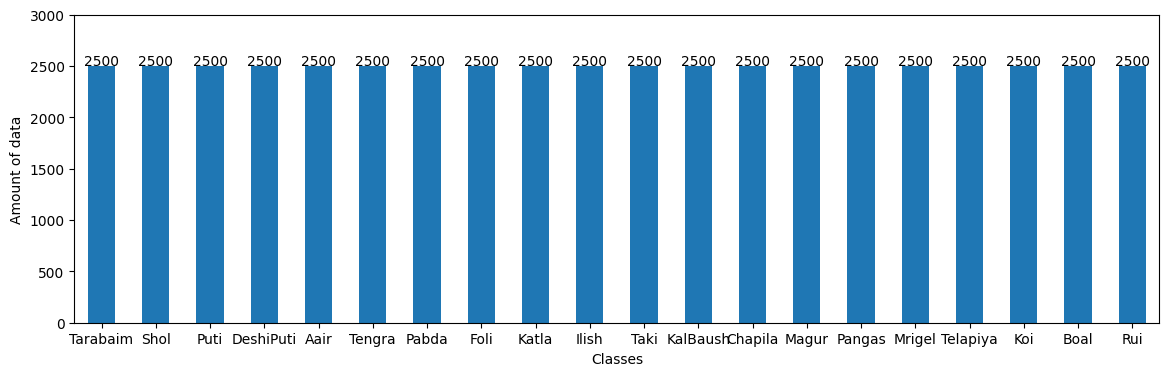

In [6]:
class_counts_train = df['label'].value_counts()

for class_name, count in class_counts_train.items():
    print(f"Class: {class_name}, Count: {count}")

plt.figure(figsize=(14, 4))
ax = class_counts_train.plot(kind='bar')
plt.xlabel('Classes')
plt.ylabel('Amount of data')
plt.xticks(rotation=360)
for i, count in enumerate(class_counts_train):
    ax.text(i, count + 5, str(count), ha='center')
plt.ylim(0, max(class_counts_train) * 1.2)
plt.show()

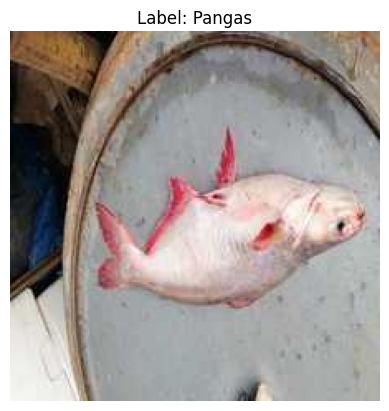

In [7]:
random_index = random.randint(1, len(df) - 1)
random_row = df.iloc[random_index]

file_path = random_row['file_path']
label = random_row['label']

image = Image.open(file_path)
plt.imshow(image)
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()


# Train-Test-Validation Split (Ratio 70:15:15)

In [8]:
train_dataframe, temp_dataframe = train_test_split(df, test_size=0.30, 
                                     stratify=df['label'], random_state=42)
valid_dataframe, test_df = train_test_split(temp_dataframe, test_size=0.50, 
                                            stratify=temp_dataframe['label'], random_state=42)

In [9]:
print("Training Data: ", len(train_dataframe))
print("Validation Data: ", len(valid_dataframe))
print("Test Data: ", len(test_df))
print("-------------------------------------------")
print("Total amounts of data in the dataset: ", len(df))

Training Data:  35000
Validation Data:  7500
Test Data:  7500
-------------------------------------------
Total amounts of data in the dataset:  50000


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Checkpoint

In [11]:
save_path_checkpoints = "/kaggle/working/"
os.makedirs(save_path_checkpoints, exist_ok=True)

# Dataset Class, Dataloader and Transform

In [12]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, normalize, is_lb=False):
        self.dataframe = dataframe
        self.normalize = normalize
        self.is_lb = is_lb
        class_names = sorted(self.dataframe['label'].unique())  # Ensure consistent order
        self.label_map = {class_name: idx for idx, class_name in enumerate(class_names)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        img_path = self.dataframe.iloc[index]['file_path']
        image = PIL.Image.open(img_path)

        if self.is_lb:
            label = self.label_map[self.dataframe.iloc[index]['label']]
            return self.normalize(image), label
        else:
            return self.normalize(image), self.normalize(image)

In [13]:
normalize = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = ImageDataset(train_dataframe, normalize, is_lb=True)
print(train_dataset.label_map)

{'Aair': 0, 'Boal': 1, 'Chapila': 2, 'DeshiPuti': 3, 'Foli': 4, 'Ilish': 5, 'KalBaush': 6, 'Katla': 7, 'Koi': 8, 'Magur': 9, 'Mrigel': 10, 'Pabda': 11, 'Pangas': 12, 'Puti': 13, 'Rui': 14, 'Shol': 15, 'Taki': 16, 'Tarabaim': 17, 'Telapiya': 18, 'Tengra': 19}


In [14]:
train_batch = 32
val_batch = 8

def data_transfrom():
    normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])

    train_dataset = ImageDataset (
        train_dataframe,
        normalize,
        is_lb=True
    )

    valid_dataset = ImageDataset(
        valid_dataframe,
        normalize,
        is_lb=True
    )

    test_dataset = ImageDataset(
        test_df,
        normalize,
        is_lb=True
    )

    dataloader_train_dataset = DataLoader(train_dataset, batch_size = train_batch, shuffle=True, num_workers=2)
    dataloader_valid_dataset = DataLoader(valid_dataset, batch_size = val_batch, shuffle=False, num_workers=2)
    dataloader_test_dataset = DataLoader(test_dataset, batch_size = val_batch, shuffle=False, num_workers=2)

    return dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset

dataloader_train_dataset, dataloader_valid_dataset, dataloader_test_dataset = data_transfrom()

# Neural Network(ResNET50)

In [15]:
total_class = 20
learning_rate = 0.0001


model = models.resnet50(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, total_class)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 232MB/s]


In [16]:
summary(model, input_size=(train_batch, 3, 224, 224)) 

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 20]                  --
├─Conv2d: 1-1                            [32, 64, 112, 112]        (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [32, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]   

# Training

In [17]:
start_time = time.time()

def train_model(model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, num_epochs=100, save_path_checkpoints="checkpoints"):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    best_val_acc = 0.0

    for epoch in range(num_epochs):
        
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        progress_bar = tqdm(enumerate(dataloader_train_dataset), total=len(dataloader_train_dataset))
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=running_loss / total_train, acc=correct_train / total_train)

        epoch_train_loss = running_loss / total_train
        epoch_train_acc = correct_train / total_train
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        print('Training Loss: {:.3f} Acc: {:.3f}'.format(epoch_train_loss, epoch_train_acc))

        
        model.eval()
        running_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in dataloader_valid_dataset:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        epoch_val_loss = running_loss / total_val
        epoch_val_acc = correct_val / total_val
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print('Validation Loss: {:.3f} Acc: {:.3f}'.format(epoch_val_loss, epoch_val_acc))

        
    
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            best_epoch = epoch + 1
            filepath = f"{save_path_checkpoints}/model.pt"
            checkpoint = {
                "epoch": epoch + 1,
                "model_weight": model.state_dict(),
                "optimizer_state": optimizer.state_dict()
            }
            torch.save(checkpoint, filepath)
            print(f"Best model saved at epoch {best_epoch} with validation accuracy: {best_val_acc:.3f}")

    return train_loss_history, train_acc_history, val_loss_history, val_acc_history


train_loss_history, train_acc_history, val_loss_history, val_acc_history = train_model(
    model, criterion, optimizer, dataloader_train_dataset, dataloader_valid_dataset, save_path_checkpoints=save_path_checkpoints
)

end_time = time.time()
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds ---> {training_time/60:.2f} minutes")

data = {
    'Epoch': list(range(1, len(train_loss_history) + 1)),
    'Train Loss': train_loss_history,
    'Train Accuracy': train_acc_history,
    'Validation Loss': val_loss_history,
    'Validation Accuracy': val_acc_history
}

history = pd.DataFrame(data)
history.to_excel('/kaggle/working/training_data.xlsx', index=False)

Epoch 1/100: 100%|██████████| 1094/1094 [01:26<00:00, 12.65it/s, acc=0.74, loss=1.51]

Training Loss: 1.515 Acc: 0.740


Validation Loss: 0.760 Acc: 0.888
Best model saved at epoch 1 with validation accuracy: 0.888


Epoch 2/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.75it/s, acc=0.886, loss=0.65]

Training Loss: 0.650 Acc: 0.886


Validation Loss: 0.450 Acc: 0.920
Best model saved at epoch 2 with validation accuracy: 0.920


Epoch 3/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.78it/s, acc=0.915, loss=0.447]

Training Loss: 0.447 Acc: 0.915


Validation Loss: 0.328 Acc: 0.938
Best model saved at epoch 3 with validation accuracy: 0.938


Epoch 4/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.78it/s, acc=0.929, loss=0.351]

Training Loss: 0.351 Acc: 0.929


Validation Loss: 0.265 Acc: 0.948
Best model saved at epoch 4 with validation accuracy: 0.948


Epoch 5/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.78it/s, acc=0.939, loss=0.294]

Training Loss: 0.294 Acc: 0.939


Validation Loss: 0.227 Acc: 0.953
Best model saved at epoch 5 with validation accuracy: 0.953


Epoch 6/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.77it/s, acc=0.942, loss=0.256]

Training Loss: 0.256 Acc: 0.942


Validation Loss: 0.205 Acc: 0.957
Best model saved at epoch 6 with validation accuracy: 0.957


Epoch 7/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.77it/s, acc=0.949, loss=0.23]

Training Loss: 0.230 Acc: 0.949


Validation Loss: 0.182 Acc: 0.959
Best model saved at epoch 7 with validation accuracy: 0.959


Epoch 8/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.73it/s, acc=0.952, loss=0.205]

Training Loss: 0.205 Acc: 0.952


Validation Loss: 0.167 Acc: 0.960
Best model saved at epoch 8 with validation accuracy: 0.960


Epoch 9/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.71it/s, acc=0.956, loss=0.191]

Training Loss: 0.191 Acc: 0.956


Validation Loss: 0.156 Acc: 0.966
Best model saved at epoch 9 with validation accuracy: 0.966


Epoch 10/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.74it/s, acc=0.958, loss=0.18]

Training Loss: 0.180 Acc: 0.958


Validation Loss: 0.142 Acc: 0.966
Best model saved at epoch 10 with validation accuracy: 0.966


Epoch 11/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.70it/s, acc=0.959, loss=0.167]

Training Loss: 0.167 Acc: 0.959


Validation Loss: 0.137 Acc: 0.965


Epoch 12/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.77it/s, acc=0.963, loss=0.157]

Training Loss: 0.157 Acc: 0.963


Validation Loss: 0.131 Acc: 0.966


Epoch 13/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.67it/s, acc=0.964, loss=0.15]

Training Loss: 0.150 Acc: 0.964


Validation Loss: 0.121 Acc: 0.968
Best model saved at epoch 13 with validation accuracy: 0.968


Epoch 14/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.71it/s, acc=0.966, loss=0.143]

Training Loss: 0.143 Acc: 0.966


Validation Loss: 0.118 Acc: 0.969
Best model saved at epoch 14 with validation accuracy: 0.969


Epoch 15/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.76it/s, acc=0.966, loss=0.137]

Training Loss: 0.137 Acc: 0.966


Validation Loss: 0.113 Acc: 0.970
Best model saved at epoch 15 with validation accuracy: 0.970


Epoch 16/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.73it/s, acc=0.968, loss=0.131]

Training Loss: 0.131 Acc: 0.968


Validation Loss: 0.105 Acc: 0.972
Best model saved at epoch 16 with validation accuracy: 0.972


Epoch 17/100: 100%|██████████| 1094/1094 [01:13<00:00, 14.79it/s, acc=0.968, loss=0.129]

Training Loss: 0.129 Acc: 0.968


Validation Loss: 0.104 Acc: 0.971


Epoch 18/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.76it/s, acc=0.971, loss=0.12]

Training Loss: 0.120 Acc: 0.971


Validation Loss: 0.101 Acc: 0.972


Epoch 19/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.74it/s, acc=0.971, loss=0.118]

Training Loss: 0.118 Acc: 0.971


Validation Loss: 0.100 Acc: 0.973
Best model saved at epoch 19 with validation accuracy: 0.973


Epoch 20/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.74it/s, acc=0.971, loss=0.114]

Training Loss: 0.114 Acc: 0.971


Validation Loss: 0.096 Acc: 0.975
Best model saved at epoch 20 with validation accuracy: 0.975


Epoch 21/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.73it/s, acc=0.972, loss=0.111]

Training Loss: 0.111 Acc: 0.972


Validation Loss: 0.096 Acc: 0.974


Epoch 22/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.74it/s, acc=0.973, loss=0.106]

Training Loss: 0.106 Acc: 0.973


Validation Loss: 0.091 Acc: 0.976
Best model saved at epoch 22 with validation accuracy: 0.976


Epoch 23/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.75it/s, acc=0.973, loss=0.105]

Training Loss: 0.105 Acc: 0.973


Validation Loss: 0.090 Acc: 0.973


Epoch 24/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.78it/s, acc=0.974, loss=0.103]

Training Loss: 0.103 Acc: 0.974


Validation Loss: 0.088 Acc: 0.977
Best model saved at epoch 24 with validation accuracy: 0.977


Epoch 25/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.74it/s, acc=0.974, loss=0.101]

Training Loss: 0.101 Acc: 0.974


Validation Loss: 0.088 Acc: 0.976


Epoch 26/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.75it/s, acc=0.975, loss=0.098]

Training Loss: 0.098 Acc: 0.975


Validation Loss: 0.086 Acc: 0.977


Epoch 27/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.69it/s, acc=0.977, loss=0.0933]

Training Loss: 0.093 Acc: 0.977


Validation Loss: 0.085 Acc: 0.975


Epoch 28/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.74it/s, acc=0.975, loss=0.0938]

Training Loss: 0.094 Acc: 0.975


Validation Loss: 0.085 Acc: 0.976


Epoch 29/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.72it/s, acc=0.976, loss=0.0903]

Training Loss: 0.090 Acc: 0.976


Validation Loss: 0.079 Acc: 0.978
Best model saved at epoch 29 with validation accuracy: 0.978


Epoch 30/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.76it/s, acc=0.977, loss=0.088]

Training Loss: 0.088 Acc: 0.977


Validation Loss: 0.078 Acc: 0.978


Epoch 31/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.74it/s, acc=0.976, loss=0.0881]

Training Loss: 0.088 Acc: 0.976


Validation Loss: 0.079 Acc: 0.977


Epoch 32/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.76it/s, acc=0.978, loss=0.0847]

Training Loss: 0.085 Acc: 0.978


Validation Loss: 0.075 Acc: 0.978


Epoch 33/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.75it/s, acc=0.979, loss=0.0834]

Training Loss: 0.083 Acc: 0.979


Validation Loss: 0.075 Acc: 0.979
Best model saved at epoch 33 with validation accuracy: 0.979


Epoch 34/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.77it/s, acc=0.979, loss=0.0816]

Training Loss: 0.082 Acc: 0.979


Validation Loss: 0.074 Acc: 0.980
Best model saved at epoch 34 with validation accuracy: 0.980


Epoch 35/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.74it/s, acc=0.979, loss=0.0801]

Training Loss: 0.080 Acc: 0.979


Validation Loss: 0.073 Acc: 0.980


Epoch 36/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.75it/s, acc=0.98, loss=0.0782]

Training Loss: 0.078 Acc: 0.980


Validation Loss: 0.073 Acc: 0.978


Epoch 37/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.74it/s, acc=0.981, loss=0.0771]

Training Loss: 0.077 Acc: 0.981


Validation Loss: 0.073 Acc: 0.979


Epoch 38/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.73it/s, acc=0.98, loss=0.0767]

Training Loss: 0.077 Acc: 0.980


Validation Loss: 0.073 Acc: 0.978


Epoch 39/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.69it/s, acc=0.981, loss=0.0752]

Training Loss: 0.075 Acc: 0.981


Validation Loss: 0.072 Acc: 0.979


Epoch 40/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.74it/s, acc=0.981, loss=0.0726]

Training Loss: 0.073 Acc: 0.981


Validation Loss: 0.071 Acc: 0.978


Epoch 41/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.68it/s, acc=0.982, loss=0.0718]

Training Loss: 0.072 Acc: 0.982


Validation Loss: 0.071 Acc: 0.978


Epoch 42/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.74it/s, acc=0.982, loss=0.0715]

Training Loss: 0.071 Acc: 0.982


Validation Loss: 0.074 Acc: 0.978


Epoch 43/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.78it/s, acc=0.982, loss=0.0696]

Training Loss: 0.070 Acc: 0.982


Validation Loss: 0.067 Acc: 0.981
Best model saved at epoch 43 with validation accuracy: 0.981


Epoch 44/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.76it/s, acc=0.982, loss=0.0694]

Training Loss: 0.069 Acc: 0.982


Validation Loss: 0.068 Acc: 0.981


Epoch 45/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.76it/s, acc=0.983, loss=0.0671]

Training Loss: 0.067 Acc: 0.983


Validation Loss: 0.069 Acc: 0.980


Epoch 46/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.74it/s, acc=0.983, loss=0.0663]

Training Loss: 0.066 Acc: 0.983


Validation Loss: 0.066 Acc: 0.980


Epoch 47/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.72it/s, acc=0.983, loss=0.0668]

Training Loss: 0.067 Acc: 0.983


Validation Loss: 0.063 Acc: 0.982
Best model saved at epoch 47 with validation accuracy: 0.982


Epoch 48/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.77it/s, acc=0.984, loss=0.0645]

Training Loss: 0.065 Acc: 0.984


Validation Loss: 0.064 Acc: 0.980


Epoch 49/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.78it/s, acc=0.985, loss=0.062]

Training Loss: 0.062 Acc: 0.985


Validation Loss: 0.065 Acc: 0.980


Epoch 50/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.74it/s, acc=0.983, loss=0.0642]

Training Loss: 0.064 Acc: 0.983


Validation Loss: 0.065 Acc: 0.981


Epoch 51/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.77it/s, acc=0.985, loss=0.0612]

Training Loss: 0.061 Acc: 0.985


Validation Loss: 0.064 Acc: 0.980


Epoch 52/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.73it/s, acc=0.984, loss=0.0602]

Training Loss: 0.060 Acc: 0.984


Validation Loss: 0.062 Acc: 0.981


Epoch 53/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.74it/s, acc=0.985, loss=0.0598]

Training Loss: 0.060 Acc: 0.985


Validation Loss: 0.065 Acc: 0.980


Epoch 54/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.74it/s, acc=0.984, loss=0.0615]

Training Loss: 0.061 Acc: 0.984


Validation Loss: 0.061 Acc: 0.982


Epoch 55/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.68it/s, acc=0.985, loss=0.0597]

Training Loss: 0.060 Acc: 0.985


Validation Loss: 0.062 Acc: 0.981


Epoch 56/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.72it/s, acc=0.984, loss=0.0593]

Training Loss: 0.059 Acc: 0.984


Validation Loss: 0.063 Acc: 0.981


Epoch 57/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.76it/s, acc=0.986, loss=0.057]

Training Loss: 0.057 Acc: 0.986


Validation Loss: 0.059 Acc: 0.981


Epoch 58/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.72it/s, acc=0.986, loss=0.0557]

Training Loss: 0.056 Acc: 0.986


Validation Loss: 0.057 Acc: 0.983
Best model saved at epoch 58 with validation accuracy: 0.983


Epoch 59/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.75it/s, acc=0.986, loss=0.0559]

Training Loss: 0.056 Acc: 0.986


Validation Loss: 0.059 Acc: 0.984
Best model saved at epoch 59 with validation accuracy: 0.984


Epoch 60/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.68it/s, acc=0.985, loss=0.0557]

Training Loss: 0.056 Acc: 0.985


Validation Loss: 0.060 Acc: 0.982


Epoch 61/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.71it/s, acc=0.986, loss=0.0543]

Training Loss: 0.054 Acc: 0.986


Validation Loss: 0.059 Acc: 0.983


Epoch 62/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.74it/s, acc=0.986, loss=0.0543]

Training Loss: 0.054 Acc: 0.986


Validation Loss: 0.061 Acc: 0.982


Epoch 63/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.73it/s, acc=0.987, loss=0.0539]

Training Loss: 0.054 Acc: 0.987


Validation Loss: 0.057 Acc: 0.984


Epoch 64/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.71it/s, acc=0.987, loss=0.0526]

Training Loss: 0.053 Acc: 0.987


Validation Loss: 0.058 Acc: 0.983


Epoch 65/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.73it/s, acc=0.986, loss=0.0538]

Training Loss: 0.054 Acc: 0.986


Validation Loss: 0.058 Acc: 0.983


Epoch 66/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.68it/s, acc=0.987, loss=0.0518]

Training Loss: 0.052 Acc: 0.987


Validation Loss: 0.056 Acc: 0.983


Epoch 67/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.69it/s, acc=0.987, loss=0.0507]

Training Loss: 0.051 Acc: 0.987


Validation Loss: 0.058 Acc: 0.983


Epoch 68/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.70it/s, acc=0.987, loss=0.0519]

Training Loss: 0.052 Acc: 0.987


Validation Loss: 0.059 Acc: 0.982


Epoch 69/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.73it/s, acc=0.987, loss=0.0503]

Training Loss: 0.050 Acc: 0.987


Validation Loss: 0.058 Acc: 0.982


Epoch 70/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.68it/s, acc=0.987, loss=0.0501]

Training Loss: 0.050 Acc: 0.987


Validation Loss: 0.059 Acc: 0.981


Epoch 71/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.69it/s, acc=0.987, loss=0.0494]

Training Loss: 0.049 Acc: 0.987


Validation Loss: 0.054 Acc: 0.983


Epoch 72/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.70it/s, acc=0.988, loss=0.0479]

Training Loss: 0.048 Acc: 0.988


Validation Loss: 0.056 Acc: 0.983


Epoch 73/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.70it/s, acc=0.988, loss=0.0486]

Training Loss: 0.049 Acc: 0.988


Validation Loss: 0.054 Acc: 0.983


Epoch 74/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.71it/s, acc=0.988, loss=0.0484]

Training Loss: 0.048 Acc: 0.988


Validation Loss: 0.055 Acc: 0.984
Best model saved at epoch 74 with validation accuracy: 0.984


Epoch 75/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.70it/s, acc=0.988, loss=0.0475]

Training Loss: 0.047 Acc: 0.988


Validation Loss: 0.055 Acc: 0.983


Epoch 76/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.70it/s, acc=0.988, loss=0.0465]

Training Loss: 0.047 Acc: 0.988


Validation Loss: 0.053 Acc: 0.984


Epoch 77/100: 100%|██████████| 1094/1094 [01:16<00:00, 14.32it/s, acc=0.989, loss=0.0457]

Training Loss: 0.046 Acc: 0.989


Validation Loss: 0.054 Acc: 0.983


Epoch 78/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.78it/s, acc=0.988, loss=0.0465]

Training Loss: 0.046 Acc: 0.988


Validation Loss: 0.053 Acc: 0.983


Epoch 79/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.67it/s, acc=0.988, loss=0.0468]

Training Loss: 0.047 Acc: 0.988


Validation Loss: 0.054 Acc: 0.983


Epoch 80/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.69it/s, acc=0.989, loss=0.0441]

Training Loss: 0.044 Acc: 0.989


Validation Loss: 0.055 Acc: 0.983


Epoch 81/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.68it/s, acc=0.989, loss=0.0453]

Training Loss: 0.045 Acc: 0.989


Validation Loss: 0.052 Acc: 0.984


Epoch 82/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.67it/s, acc=0.988, loss=0.0441]

Training Loss: 0.044 Acc: 0.988


Validation Loss: 0.053 Acc: 0.983


Epoch 83/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.69it/s, acc=0.988, loss=0.0453]

Training Loss: 0.045 Acc: 0.988


Validation Loss: 0.052 Acc: 0.984


Epoch 84/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.64it/s, acc=0.989, loss=0.0436]

Training Loss: 0.044 Acc: 0.989


Validation Loss: 0.051 Acc: 0.984


Epoch 85/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.60it/s, acc=0.989, loss=0.0437]

Training Loss: 0.044 Acc: 0.989


Validation Loss: 0.052 Acc: 0.983


Epoch 86/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.69it/s, acc=0.99, loss=0.0416]

Training Loss: 0.042 Acc: 0.990


Validation Loss: 0.051 Acc: 0.985
Best model saved at epoch 86 with validation accuracy: 0.985


Epoch 87/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.78it/s, acc=0.99, loss=0.0413]

Training Loss: 0.041 Acc: 0.990


Validation Loss: 0.052 Acc: 0.983


Epoch 88/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.78it/s, acc=0.989, loss=0.0419]

Training Loss: 0.042 Acc: 0.989


Validation Loss: 0.051 Acc: 0.984


Epoch 89/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.70it/s, acc=0.99, loss=0.0412]

Training Loss: 0.041 Acc: 0.990


Validation Loss: 0.050 Acc: 0.985
Best model saved at epoch 89 with validation accuracy: 0.985


Epoch 90/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.67it/s, acc=0.99, loss=0.0405]

Training Loss: 0.040 Acc: 0.990


Validation Loss: 0.052 Acc: 0.984


Epoch 91/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.64it/s, acc=0.991, loss=0.0388]

Training Loss: 0.039 Acc: 0.991


Validation Loss: 0.050 Acc: 0.985


Epoch 92/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.69it/s, acc=0.99, loss=0.0401]

Training Loss: 0.040 Acc: 0.990


Validation Loss: 0.051 Acc: 0.983


Epoch 93/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.66it/s, acc=0.99, loss=0.0393]

Training Loss: 0.039 Acc: 0.990


Validation Loss: 0.053 Acc: 0.984


Epoch 94/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.68it/s, acc=0.99, loss=0.0401]

Training Loss: 0.040 Acc: 0.990


Validation Loss: 0.051 Acc: 0.984


Epoch 95/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.71it/s, acc=0.991, loss=0.0376]

Training Loss: 0.038 Acc: 0.991


Validation Loss: 0.049 Acc: 0.985


Epoch 96/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.66it/s, acc=0.991, loss=0.0383]

Training Loss: 0.038 Acc: 0.991


Validation Loss: 0.048 Acc: 0.985


Epoch 97/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.65it/s, acc=0.99, loss=0.0389]

Training Loss: 0.039 Acc: 0.990


Validation Loss: 0.048 Acc: 0.986
Best model saved at epoch 97 with validation accuracy: 0.986


Epoch 98/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.71it/s, acc=0.991, loss=0.0375]

Training Loss: 0.038 Acc: 0.991


Validation Loss: 0.048 Acc: 0.986


Epoch 99/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.66it/s, acc=0.991, loss=0.0378]

Training Loss: 0.038 Acc: 0.991


Validation Loss: 0.047 Acc: 0.985


Epoch 100/100: 100%|██████████| 1094/1094 [01:14<00:00, 14.67it/s, acc=0.991, loss=0.0371]

Training Loss: 0.037 Acc: 0.991


Validation Loss: 0.048 Acc: 0.985
Training Time: 9254.85 seconds ---> 154.25 minutes


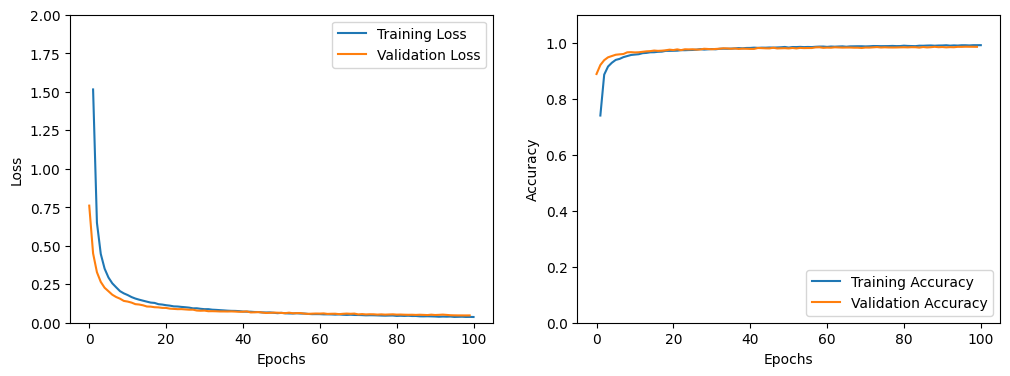

In [18]:
history = pd.read_excel('/kaggle/working/training_data.xlsx')

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['Epoch'], history['Train Loss'], label='Train Loss')
plt.plot(history['Validation Loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.ylim(0,2)

plt.subplot(1, 2, 2)
plt.plot(history['Epoch'], history['Train Accuracy'], label='Train Accuracy')
plt.plot(history['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')
plt.ylim(0,1.1)

plt.show()

# Evaluation

In [19]:
def evaluate_model(model, criterion, dataloader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = running_loss / total
    accuracy = correct / total

    return loss, accuracy

In [20]:
best_checkpoint_path = f"{save_path_checkpoints}/model.pt"
checkpoint = torch.load(best_checkpoint_path)
best_epoch = checkpoint["epoch"]
model.load_state_dict(checkpoint["model_weight"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

best_val_loss, best_val_accuracy = evaluate_model(model, criterion, dataloader_valid_dataset)
print(f"Best model (from epoch {best_epoch}) - Validation Loss: {best_val_loss:.3f}, Validation Accuracy: {best_val_accuracy:.3f}")

Best model (from epoch 97) - Validation Loss: 0.048, Validation Accuracy: 0.986


In [21]:
start_time = time.time()

test_loss, test_accuracy = evaluate_model(model, criterion, dataloader_test_dataset)
print(f"Test Accuracy: {test_accuracy:.3f}")

end_time = time.time()
test_time = end_time - start_time
print(f"Test Time: {test_time:.2f} seconds ---> {test_time/60:.2f} minutes")

Test Accuracy: 0.984
Test Time: 27.29 seconds ---> 0.45 minutes


In [22]:
def class_accuracy(model, dataloader, num_classes):
    class_correct = [0.0] * num_classes
    class_total = [0.0] * num_classes

    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels)
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1

    class_accuracy = [class_correct[i] / class_total[i] if class_total[i] > 0 else 0 for i in range(num_classes)]

    return class_accuracy

y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in dataloader_test_dataset:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

class_names = [str(i) for i in range(total_class)]

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

class_acc = class_accuracy(model, dataloader_test_dataset, total_class)
for i in range(total_class):
    print(f"Class {i} Accuracy: {class_acc[i]:.3f}")

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       375
           1       0.98      0.97      0.98       375
           2       1.00      1.00      1.00       375
           3       1.00      1.00      1.00       375
           4       0.99      0.99      0.99       375
           5       1.00      0.99      0.99       375
           6       0.97      0.98      0.97       375
           7       0.98      0.98      0.98       375
           8       1.00      1.00      1.00       375
           9       1.00      1.00      1.00       375
          10       0.99      0.99      0.99       375
          11       0.96      0.98      0.97       375
          12       1.00      1.00      1.00       375
          13       0.97      0.98      0.98       375
          14       0.98      0.97      0.97       375
          15       0.98      0.97      0.97       375
          16       0.96      0.95      0.96       375
    